In [10]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
from sklearn.utils import resample

from PIL import Image,  ImageOps
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.transform import resize

from torch.utils.tensorboard import SummaryWriter
import torchmetrics

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

dev = "cuda:0"  if torch.cuda.is_available() else "cpu" 
device = torch.device(dev) 

In [11]:
class HazelNet(nn.Module):
    
    def __init__(self):
        # wofür ist das da?
        super(HazelNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
  
        # over-write the first conv layer to be able to read images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.fc_in_features = self.resnet.fc.in_features 
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        #self.resnet.fc kann das letzte layer ansprechen und ersetzen bei bedarf

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            )        
       
        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)   
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    # Erstellt NN mit dem input, inputs ist unser batch
    def forward_once(self, inputs):
        output = self.resnet(inputs)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    
    def distance_layer(self, vec1, vec2):
        cos = torch.nn.CosineSimilarity()
        similarity = cos(vec1, vec2) 
        return similarity

    def forward(self, template, img):
        output1 = self.forward_once(template)
        output2 = self.forward_once(img)

        output = self.distance_layer(output1,output2)
 
        return output   

In [12]:
path = 'c:\\Users\\micha\\Documents\\FH Kiel\\UKSH\\Abgabe Application Project'

In [13]:
model = HazelNet().to(device)
model.load_state_dict(torch.load(f"{path}/Model/bestmodel"))

<All keys matched successfully>

In [14]:
def predict (model, template, img):
    model.eval()
    with torch.no_grad():
        ypred = model(template,img)
    return ypred

In [15]:
size = (78,194)
img = Image.open("images/Peak1.png").convert('L')
img = ImageOps.exif_transpose(img)
img = img.resize(size) 
img = ImageOps.invert(img)

template = Image.open("images/Peak2.png").convert('L')
template = ImageOps.exif_transpose(template)
template = template.resize(size) 
template = ImageOps.invert(template)

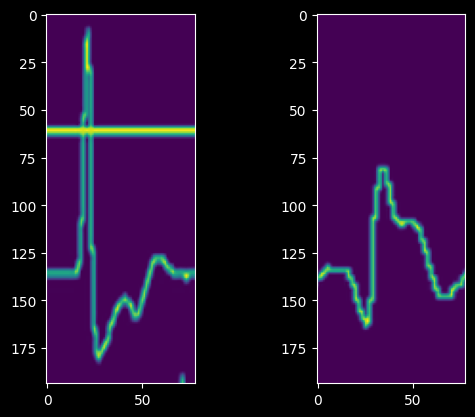

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(template)
ax[1].imshow(img)

In [17]:
convert_tensor = transforms.ToTensor()
img_pil = convert_tensor(img).to(device).unsqueeze(0)
template_pil = convert_tensor(template).to(device).unsqueeze(0)
predict(model, img_pil, template_pil)

tensor([1.0000], device='cuda:0')

In [18]:
def readImg_url (url1, url2, iswhite = False, plot = False):
    """Function for reading images into processable tensors. Can draw a picture of processed images

    Args:
        url1 (string): url to template image
        url2 (string): url to image for comparison
        iswhite (bool, optional): inverts image colors if set to true. Defaults to False.
        plot (bool, optional): plots imported images if set to true. Defaults to False.

    Returns:
        tensor, tensor: two tensors containing the processed images ready for prediction
    """
    # invert white and black if image is on white background
    if iswhite:
        realim1 = cv.bitwise_not(cv.imread(url1,0)).astype(np.float32)
        realim2 = cv.bitwise_not(cv.imread(url2,0)).astype(np.float32)
    else: 
        realim1 = cv.imread(url1,0).astype(np.float32)
        realim2 = cv.imread(url2,0).astype(np.float32)

    realim1 =  resize(realim1, (194,78))
    realim2 =  resize(realim2, (194,78))
    template = torch.tensor(realim1).unsqueeze(0).unsqueeze(0).to(device)
    img = torch.tensor(realim2.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)

    if plot:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(realim1)
        ax[1].imshow(realim2)
    return template, img      

In [19]:
def predict (model, template, img):
    """Function for predicting the correlation score between two images

    Args:
        model (HazelNet): The model to use for prediction
        template (tensor): template image
        img (tensor): image to compare to

    Returns:
        float: label containing predicted similarity score
    """
    model.eval()
    with torch.no_grad():
        ypred = model(template,img)
    return round(ypred.item(),2)

In [20]:
path = 'c:\\Users\\micha\\Documents\\FH Kiel\\UKSH\\Abgabe Application Project'
model = HazelNet().to(device)
model.load_state_dict(torch.load(f"{path}/Model/bestmodel"))

<All keys matched successfully>

0.38

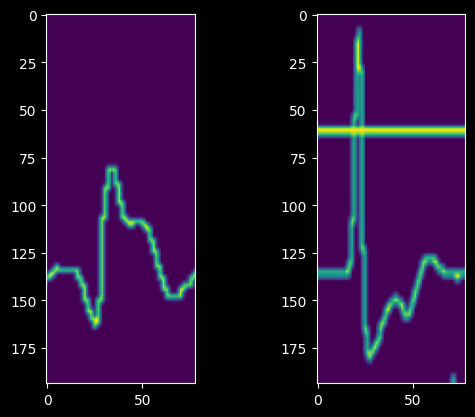

In [21]:
url1 = f"images/Peak1.png"
url2 = f"images/Peak2.png"

template, img = readImg_url(url1= url1, url2 =url2,  iswhite=True, plot=True )
predict(model = model, template = img, img = template)